<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Conditional-balances" data-toc-modified-id="Conditional-balances-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Conditional balances</a></span></li><li><span><a href="#Shotgun-validation" data-toc-modified-id="Shotgun-validation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Shotgun validation</a></span></li><li><span><a href="#Random-Forest-Feature-Importance" data-toc-modified-id="Random-Forest-Feature-Importance-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Random Forest Feature Importance</a></span></li><li><span><a href="#Random-Forests-scratch" data-toc-modified-id="Random-Forests-scratch-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Random Forests scratch</a></span></li><li><span><a href="#Scratch" data-toc-modified-id="Scratch-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Scratch</a></span></li></ul></div>

In [1]:
# This block is just for importing the necessary libraries.  
import os
from collections import defaultdict
# Numerical libraries
import pandas as pd
import numpy as np
import numpy.ma as ma

import biom
import arviz as az
from scipy.spatial.distance import euclidean
# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve

from scipy.special import expit as sigmoid
from skbio.diversity._util import _vectorize_counts_and_tree
from bp import parse_newick, to_skbio_treenode, to_skbio_treearray
from q2_matchmaker._stats import spherical_test
from util import (extract_differentials, 
                  extract_differentials_from_folder, 
                  select_features, 
                  get_genomic_data, collapse_transcripts, 
                  aggregate_pathways,
                  ranking, btest, log_pvalue, read_kegg_dict,
                  ilr_transform_differentials,
                  rename_clades, create_projection,
                  match_all_differentials,
                  match_all_differentials_and_tree)
from pls import AgeSexClassifier
from plot import (rankplot, networkplot, vectorplot)
import random

# directory paths
amp_directory = '../sfari/data/sra'
wgs_directory = '../sfari/data/sra_shotgun/Combined'
rna_directory = '../sfari/data/recount3'
kang_directory = '../sfari/data/sra/Kang2017'
sepp_directory = '../sfari/data/sra/Kang2017/deblur/sepp'
berding_directory = '../sfari/data/sra/Berding2020'

results_dir = '../results'
gbm_amp_dir = f'{results_dir}/gbm/amp'
gbm_sms_dir = f'{results_dir}/gbm/sms'
kegg_dir = f'{results_dir}/kegg'
hsa_dir = f'{results_dir}/hsa_kegg'
np.random.seed(0)
random.seed(0)
%matplotlib inline

from plot import rankplot

pd.options.display.max_rows = 100 

# Conditional balances

Age-sex matched balances using differential abundance

In [2]:
amp_studies = ['Fasano2020', 'Fouquier2021', 'Chen2020', 'Dan2020', 
               'Zou2020', 'Zurita2019', 'Berding2020', 'Kang2017']
amp_training = {'Fasano2020', 
                'Fouquier2021', 
                'Dan2020', 
                'Zou2020',
                'Berding2020',
                'Zurita2019',
                'Chen2020'
               }
sms_studies = ['Dan2020', 'Averina2020', 'Wang2021']
#amp_fnames = list(map(lambda x: f'{amp_directory}/{x}/age_sex_matched_posterior-v2.nc', amp_studies))
amp_fnames = list(map(lambda x: f'{amp_directory}/{x}/age_sex_matched_posterior', amp_studies))


amp_bioms = list(map(lambda x: f'{amp_directory}/{x}/deblur/vsearch/clustered_table/feature-table.biom',
                     amp_studies))
amp_bioms = dict(list(zip(amp_studies, list(map(biom.load_table, amp_bioms)))))
amp_diffs = dict(list(zip(amp_studies, list(map(extract_differentials, amp_fnames)))))

# load biom tables
amp_biom = biom.load_table(f'{kang_directory}/age_sex_match_week0-v2.biom')
wgs_biom = biom.load_table(f'{wgs_directory}/ogus_table-v2.biom')
amp_table = amp_biom.to_dataframe().T
wgs_table = wgs_biom.to_dataframe().T

# load metadata tables
amp_md = pd.read_table(f'{kang_directory}/combined_sample_metadata_0.txt', index_col=0)
wgs_md = pd.read_table(f'{wgs_directory}/sample_metadata.txt', index_col=0)

amp_md = amp_md.loc[amp_table.index]
wgs_table = wgs_table.loc[wgs_md.index]

Comparison against Random Forests

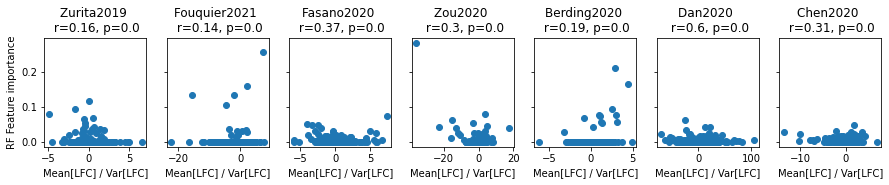

In [3]:
from scipy.stats import spearmanr

amp_gbm = {s:pd.read_table(f'{gbm_amp_dir}/{s}/feature_imporance/importance.tsv', index_col=0) 
           for s in amp_training}

fig, ax = plt.subplots(1, len(amp_training), figsize=(15, 2), sharey=True)

for i, s in enumerate(amp_training):
    fm = amp_gbm[s]
    diff = amp_diffs[s] - amp_diffs[s].mean(axis=0)
    diff = amp_diffs[s].mean(axis=1) / amp_diffs[s].var(axis=1)
    fm = fm.reindex(diff.index)
    fm = fm.fillna(0)
    #diff = diff.loc[fm.index]
    r, p = spearmanr(np.abs(diff), fm)
    r, p = np.round(r, 2), np.round(p, 2)
    ax[i].scatter(diff.values, fm.values)
    ax[i].set_title(f'{s} \n r={r}, p={p}')
    ax[i].set_xlabel('Mean[LFC] / Var[LFC]')
    if i == 0:
        ax[i].set_ylabel('RF Feature importance')

Rank plots and age-sex matched classifiers

Zurita2019 separation : 0.95 diff detected False, Effect size 0.78 Num (>0) 53 Num (<0) 24
Fouquier2021 separation : 1.0 diff detected False, Effect size 0.96 Num (>0) 63 Num (<0) 79
Fasano2020 separation : 0.95 diff detected False, Effect size 0.76 Num (>0) 91 Num (<0) 18
Zou2020 separation : 1.0 diff detected False, Effect size 0.93 Num (>0) 104 Num (<0) 54
Berding2020 separation : 0.96 diff detected False, Effect size 0.79 Num (>0) 28 Num (<0) 23
Dan2020 separation : 0.94 diff detected True, Effect size 1.71 Num (>0) 259 Num (<0) 218
Chen2020 separation : 0.74 diff detected False, Effect size 0.76 Num (>0) 49 Num (<0) 19


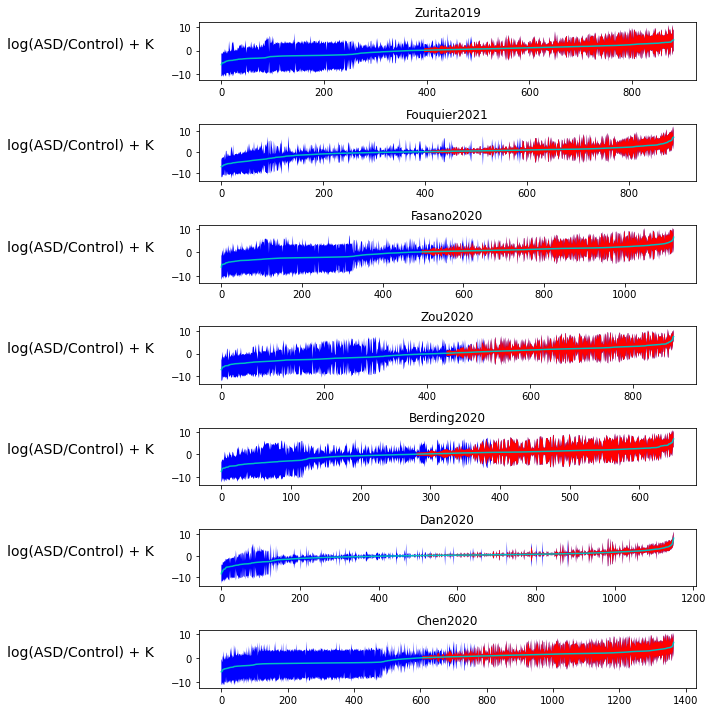

In [4]:
spectra = {}
cc_diffs = {}
fig, ax = plt.subplots(len(amp_training), figsize=(10, 10))
for i, study in enumerate(amp_training):
    ad = amp_diffs[study]
    ad = ad.loc[list(set(amp_table.columns) & set(ad.index))]
    ad = ad - ad.mean(axis=0)
    m = AgeSexClassifier(amp_diffs[study], threshold=0, percentile=0.7)
    df, md = amp_bioms[study].to_dataframe().T.align(amp_md, join='inner', axis=0)
    spectra[study] = m.balance()
    rankplot(ranking(amp_diffs[study], reference_frame=0), ax=ax[i])
    ax[i].set_title(study)
    diff = m.predict(df, md['Status'], md['Match_IDs'])
    cc_diffs[study] = diff
    w, r, z = spherical_test(ad.values.T, percentile=95)
    #w, r, z = phylogenetic_spherical_test(ad.values.T, ad.index, tree, percentile=95)
    print(study, f'separation : {np.round(np.mean(diff > 0), 2)} ' 
          f'diff detected {not w}, '
          f'Effect size {np.round(z/r, 2)} '
          f'Num (>0) {np.sum((ad > 0).mean(axis=1).sort_values() > 0.95)} '
          f'Num (<0) {np.sum((ad > 0).mean(axis=1).sort_values() < 0.05)}'
         )
plt.tight_layout()

In [5]:
clusters = {c: m['cluster_name'] for c, m in spectra.items()}
clusters = pd.DataFrame(clusters)
clusters = clusters.fillna('neutral')
clusters = clusters.loc[list(set(clusters.index) & set(amp_table.columns))]
clusters['group_logodds'] = np.log(
    (np.sum(clusters == 'num', axis=1) + 1) / (np.sum(clusters == 'denom', axis=1) + 1)
)

In [6]:
num_taxa = set(clusters.loc[np.sum(clusters == 'num', axis=1) > 1].index)
denom_taxa = set(list(clusters.loc[np.sum(clusters == 'denom', axis=1) > 1].index))
common_taxa = num_taxa & denom_taxa
num_taxa = list(num_taxa - common_taxa)
denom_taxa = list(denom_taxa - common_taxa)
"""
num_taxa = clusters.query("group_logodds > 0").index
denom_taxa = clusters.query("group_logodds < 0").index
"""

#denom_taxa += list(clusters.loc[np.mean(clusters == 'neutral', axis=1) == 1].index)
#denom_taxa = list(set(amp_table.columns) - set(num_taxa))

balance = np.log(amp_table[num_taxa] + 1).mean(axis=1) - np.log(amp_table[denom_taxa] + 1).mean(axis=1)

## SLR balances
#balance = np.log(amp_table[num_taxa].sum(axis=1) + 1) - np.log(amp_table[denom_taxa].sum(axis=1) + 1)

## masked balances
"""
def mask_f(x):
    n = set(x.loc[x > 0].index) & set(num_taxa) 
    d = set(x.loc[x > 0].index) & set(denom_taxa)
    if len(n) > 0:
        n_ = np.log(np.array(x.loc[n].values)).mean()
    else:
        n_ = 0
        
    if len(d) > 0:
        d_ = np.log(np.array(x.loc[d].values)).mean()
    else:
        d_ = 0
    return n_ - d_
"""
#balance = amp_table.apply(mask_f, axis=1)
amp_md['balance'] = balance

<AxesSubplot:xlabel='Cohort', ylabel='balance'>

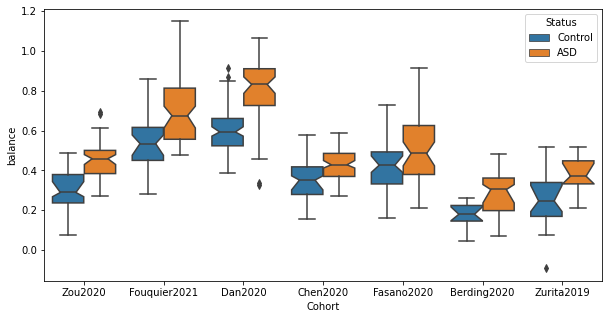

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=amp_md, hue='Status', x='Cohort', y='balance', ax=ax, notch=True, bootstrap=1000,
            order=['Zou2020', 'Fouquier2021', 'Dan2020', 'Chen2020', 'Fasano2020', 'Berding2020', 
                   'Zurita2019'])

In [8]:
for study in list(set(amp_studies) - amp_training):
    md = amp_md.loc[amp_md['Cohort'] == study].sort_values('Status')
    diffs = md.groupby('Match_IDs').apply(lambda x: x['balance'][0] - x['balance'][1])
    cc_diffs[study] = diffs
    print(study, np.mean(diffs > 0))

Kang2017 0.42857142857142855


In [9]:
cc_data = pd.melt(pd.DataFrame(cc_diffs).reset_index(), id_vars='Match_IDs')
cc_data = cc_data.dropna()

Text(0.5, 1.0, 'Case Control Differences')

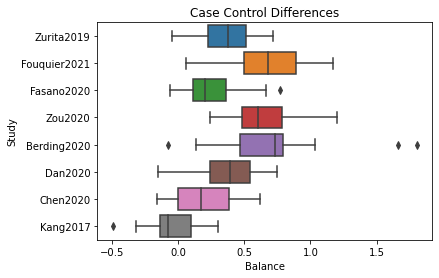

In [10]:
sns.boxplot(data=cc_data, y='variable', x='value')
plt.ylabel('Study')
plt.xlabel('Balance')
plt.title('Case Control Differences')

In [11]:
np.mean(cc_data['value'] > 0)

0.884514435695538

In [12]:
len(num_taxa), len(denom_taxa)

(593, 170)

Validate against Kang et al dataset

In [13]:
kang_md = amp_md.loc[amp_md['Cohort'] == 'Kang2017'].sort_values('Status')
kang_diffs = kang_md.groupby('Match_IDs').apply(lambda x: x['balance'][0] - x['balance'][1])   
np.mean(kang_diffs > 0)

0.42857142857142855

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

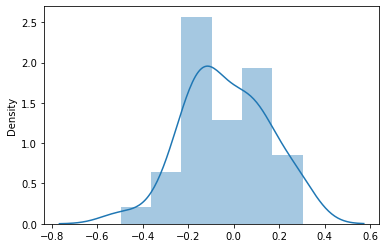

In [14]:
sns.distplot(kang_diffs)

# Shotgun validation

<AxesSubplot:xlabel='Cohort', ylabel='balance'>

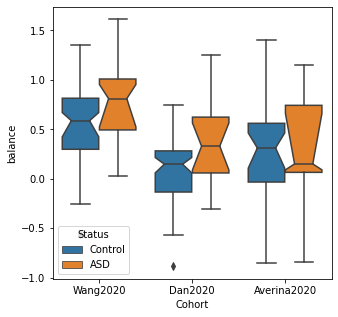

In [15]:
num_wgs = list(set(num_taxa) & set(wgs_table.columns))
denom_wgs = list(set(denom_taxa) & set(wgs_table.columns))

balance = np.log(wgs_table[num_wgs] + 1).mean(axis=1) - np.log(wgs_table[denom_wgs] + 1).mean(axis=1)

## SLR balances
#balance = np.log(wgs_table[num_wgs].sum(axis=1) + 1) - np.log(wgs_table[denom_wgs].sum(axis=1) + 1)

wgs_md['balance'] = balance

wgs_md = wgs_md.sort_values('Status', ascending=False)

fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(data=wgs_md, hue='Status', x='Cohort', y='balance', ax=ax, notch=True, bootstrap=1000)

In [16]:
cc_diffs = {}
for group, md in wgs_md.groupby('Match_IDs'):
    md = md.sort_values('Status')
    diff = md['balance'][0] - md['balance'][1]
    cc_diffs[group] = diff

In [17]:
wgs_md = wgs_md.sort_values('Status')
cc_diffs = wgs_md.groupby('Match_IDs').apply(lambda x: x['balance'][0] - x['balance'][1])   

cc_df = pd.DataFrame({'CaseControlDiff': cc_diffs})
wgs_match_md = wgs_md[['Cohort', 'Match_IDs']].drop_duplicates()
wgs_match_md = pd.merge(wgs_match_md.set_index('Match_IDs'), cc_df, left_index=True, right_index=True)

<AxesSubplot:xlabel='Status', ylabel='balance'>

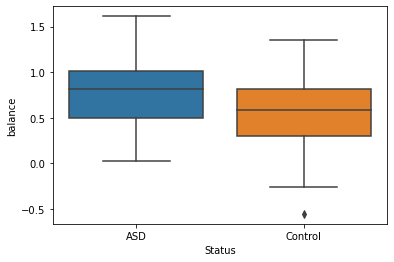

In [18]:
sns.boxplot(data=wgs_md.query('Cohort == "Wang2020"'), y='balance', x='Status')

In [19]:
len(num_wgs), len(denom_wgs)

(78, 24)

<AxesSubplot:xlabel='CaseControlDiff', ylabel='Cohort'>

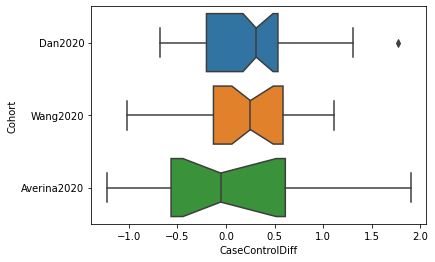

In [20]:
sns.boxplot(data=wgs_match_md, y='Cohort', x='CaseControlDiff', notch=True, bootstrap=1000)

In [21]:
cc_dict = dict(list(wgs_match_md.groupby('Cohort')))
(np.mean(cc_dict['Averina2020']['CaseControlDiff'] > 0), 
 np.mean(cc_dict['Dan2020']['CaseControlDiff'] > 0), 
 np.mean(cc_dict['Wang2020']['CaseControlDiff'] > 0))

(0.45454545454545453, 0.7333333333333333, 0.7096774193548387)

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='CaseControlDiff', ylabel='Density'>

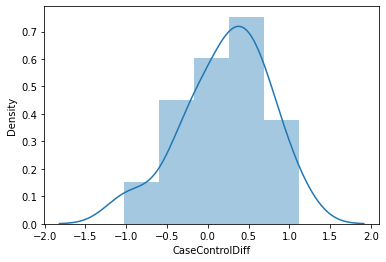

In [22]:
sns.distplot(cc_dict['Wang2020']['CaseControlDiff'])

Summarize

In [23]:
wol_taxonomy = pd.read_table('~/ceph/wol2/wol2/taxonomy/ranks.tsv', index_col=0)
gg_taxonomy = pd.read_table('~/ceph/gg2/2022.8/2022.8.taxonomy.id.tsv', index_col=0)

In [24]:
# load differentials
posterior_name = 'age_sex_matched_posterior'
#amp_fname = f'{kang_directory}/week0/differentials-v7.nc'
amp_fname = f'../sfari/data/sra/Combined/age_sex_matched_posterior/amp_differentials-v5.nc'
wgs_fname = f'{wgs_directory}/{posterior_name}/ogus_differentials-v7.nc'
amp_diffs = extract_differentials(amp_fname)
wgs_diffs = extract_differentials(wgs_fname)

amp_stats = ranking(amp_diffs, reference_percentile=50)
wgs_stats = ranking(wgs_diffs, reference_percentile=50) 

In [25]:
amp_num = pd.DataFrame(
    list(gg_taxonomy.loc[num_taxa].Taxon.apply(lambda x: x.split(';')).values),
    index=num_taxa
)
amp_num.columns = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
amp_num = pd.merge(amp_stats, amp_num, left_index=True, right_index=True)

amp_denom = pd.DataFrame(
    list(gg_taxonomy.loc[denom_taxa].Taxon.apply(lambda x: x.split(';')).values),
    index=denom_taxa,
)
amp_denom.columns = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
amp_denom = pd.merge(amp_stats, amp_denom, left_index=True, right_index=True)

wgs_num = wol_taxonomy.loc[num_wgs]
wgs_denom = wol_taxonomy.loc[denom_wgs]
wgs_num = pd.merge(wgs_stats, wgs_num, left_index=True, right_index=True)
wgs_denom = pd.merge(wgs_stats, wgs_denom, left_index=True, right_index=True)

In [26]:
amp_num.to_csv('../results/pls/amplicon_numerator.csv')
amp_denom.to_csv('../results/pls/amplicon_denominator.csv')
wgs_num.to_csv('../results/pls/shotgun_numerator.csv')
wgs_denom.to_csv('../results/pls/shotgun_denominator.csv')

In [27]:
kang_diff_df = pd.melt(pd.DataFrame({'Kang2017': kang_diffs}))
amp_diff_df = cc_data[['variable', 'value']]
wgs_diff_df = wgs_match_md.rename(columns={'Cohort': 'variable', 'CaseControlDiff': 'value'})

kang_diff_df['variable'] = kang_diff_df['variable'].apply(lambda x: f'{x} (16S)')
amp_diff_df['variable'] = amp_diff_df['variable'].apply(lambda x: f'{x} (16S)')
wgs_diff_df['variable'] = wgs_diff_df['variable'].apply(lambda x: f'{x} (SMS)')

amp_diff_df['dataset'] = '16S training'
wgs_diff_df['dataset'] = 'SMS validation'
kang_diff_df['dataset'] = '16S validation'
diff_df = pd.concat((amp_diff_df, kang_diff_df, wgs_diff_df))

<ipython-input-27-c340fb03d79d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amp_diff_df['variable'] = amp_diff_df['variable'].apply(lambda x: f'{x} (16S)')


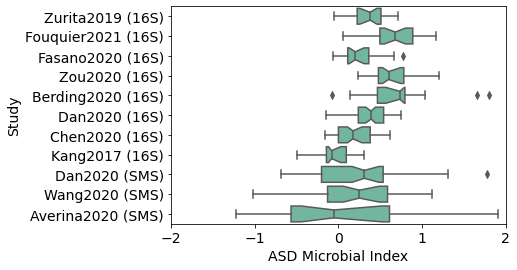

In [28]:
palette = sns.color_palette('Set2')

amp_colors = dict(zip(list(amp_diff_df['variable'].unique()),
                      [palette[0]] * len(amp_diff_df['variable'].unique())))
sms_colors = dict(zip(list(wgs_diff_df['variable'].unique()),
                  [palette[0]] * len(wgs_diff_df['variable'].unique())))
kang_colors = dict(zip(list(kang_diff_df['variable'].unique()),
                   [palette[0]] * len(kang_diff_df['variable'].unique())))

colors = {**amp_colors, **sms_colors, **kang_colors}

sns.boxplot(data=diff_df, y='variable', x='value', palette=colors, 
            notch=True, bootstrap=1000)
plt.ylabel('Study', fontsize=14)
plt.xlabel('ASD Microbial Index', fontsize=14)
plt.xlim([-2, 2])
plt.tick_params(axis='both', which='major', labelsize=14)

In [29]:
study_stats = pd.read_csv('../tables/Table1.csv').set_index(['Study', 'Type'])

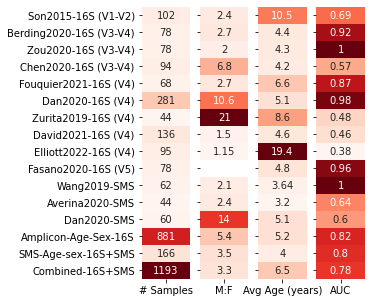

In [30]:
fig, ax = plt.subplots(1, 4, sharey=True, figsize=(4, 5))
for i in range(4):
    sns.heatmap(study_stats.iloc[:, [i]], annot=True, cmap='Reds', fmt='g', ax=ax[i], cbar=False)
    ax[i].set_ylabel('')

In [31]:
diff_df.to_csv('../figures/data/Figure2/diff_df.csv')

Comparison of age-sex matched vs sibling matched datasets

In [32]:
data_dir = '../sfari/data/sra/Combined'
age_sex_md = pd.read_table(f'{data_dir}/age_sex_match_metadata.txt', index_col=0)
sibling_md = pd.read_table(f'{data_dir}/sibling_match_metadata.txt', index_col=0)

In [33]:
round_f = lambda x: int(np.round(x))
as_age = (age_sex_md.groupby('Match_IDs')
 .apply(lambda x: round_f(x['Age'][0]) == round_f(x['Age'][1]))
 .mean())

as_sex = (age_sex_md
 .dropna(subset=['Sex'])
 .groupby('Match_IDs')
 .filter(lambda x: len(x) == 2)
 .groupby('Match_IDs')
 .apply(lambda x: x['Sex'][0] == x['Sex'][1])
 .mean())

s_age = (sibling_md
 .dropna(subset=['Age', 'Sex'])
 .groupby('Match_IDs')
 .filter(lambda x: len(x) == 2)
 .groupby('Match_IDs')
 .apply(lambda x: round_f(x['Age'][0]) == round_f(x['Age'][1]))
 .mean())

s_sex = (sibling_md
 .dropna(subset=['Sex'])
 .groupby('Match_IDs')
 .filter(lambda x: len(x) == 2)
 .groupby('Match_IDs')
 .apply(lambda x: x['Sex'][0] == x['Sex'][1])
 .mean())

<ipython-input-34-e8fd28df4705>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(['', 'Age-sex \n matched', '', 'Sibling \n matched'])
<ipython-input-34-e8fd28df4705>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(['', 'Age-sex \n matched', '', 'Sibling \n matched'])


Text(0.5, 1.0, 'Case-Control pairs \n sex matched')

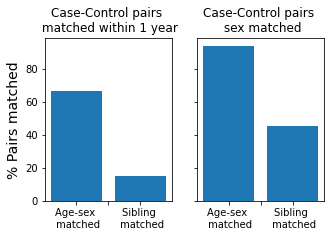

In [34]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(5, 3))
ax[0].bar([0, 1], [as_age * 100, s_age * 100])
ax[0].set_xticklabels(['', 'Age-sex \n matched', '', 'Sibling \n matched'])
#ax[0].set_yticks([])
ax[0].set_title('Case-Control pairs \n matched within 1 year')
ax[0].set_ylabel('% Pairs matched', fontsize=14)

ax[1].bar([0, 1], [as_sex * 100, s_sex * 100])
ax[1].set_xticklabels(['', 'Age-sex \n matched', '', 'Sibling \n matched'])
ax[1].set_title('Case-Control pairs \n sex matched')

<ipython-input-44-5ef690a44928>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(['', 'Age-sex \n matched', '', 'Sibling \n matched'])
<ipython-input-44-5ef690a44928>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(['', 'Age-sex \n matched', '', 'Sibling \n matched'])


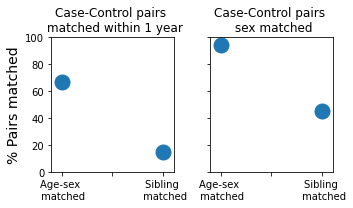

In [44]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(5, 3))
ax[0].plot([0, 1], [as_age * 100, s_age * 100], marker='o', lw=0, markersize=15)
ax[0].set_xticklabels(['', 'Age-sex \n matched', '', 'Sibling \n matched'])
#ax[0].set_yticks([])
ax[0].set_title('Case-Control pairs \n matched within 1 year')
ax[0].set_ylabel('% Pairs matched', fontsize=14)
ax[0].set_ylim([0, 100])
ax[0].set_xlim([-0.1, 1.1])

ax[1].plot([0, 1], [as_sex * 100, s_sex * 100], marker='o', lw=0, markersize=15)
ax[1].set_xticklabels(['', 'Age-sex \n matched', '', 'Sibling \n matched'])
ax[1].set_title('Case-Control pairs \n sex matched')
ax[1].set_ylim([0, 100])
ax[1].set_xlim([-0.1, 1.1])

plt.tight_layout()

# Random Forest Feature Importance

In [ ]:
import qiime2
import shap
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

fname = '../results/gbm/amp/Combined/probabilities.qza'
pred_probs = qiime2.Artifact.load(fname).view(pd.DataFrame)

fname = '../results/gbm/amp/Combined/feature_importance.qza'
feature_importances = qiime2.Artifact.load(fname).view(pd.DataFrame)

fname = '../sfari/data/sra/Combined/age_sex_matched-v2.biom'
table = biom.load_table(fname).to_dataframe().T
X_test = table.loc[pred_probs.index, feature_importances.index]

fname = '../sfari/data/sra/Combined/age_sex_match_metadata.txt'
md_test = pd.read_table(fname, index_col=0).loc[X_test.index]

fname = '../results/gbm/amp/Combined/sample_estimator.qza'
model = qiime2.Artifact.load(fname).view(Pipeline)
explainer = shap.TreeExplainer(model['est'])
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(shap_values, X_test, max_display=30)

In [ ]:
shap_values = pd.DataFrame(shap_values, index=X_test.index, columns=feature_importances.index)
shap_values.to_csv('../results/amp_agesex_shap.csv')

In [ ]:
shap_values.mean(axis=0).sort_values()

In [ ]:
# Random forests feature importance
amp_stats = pd.merge(amp_stats, feature_importances, left_index=True, right_index=True, how='outer')

In [ ]:
# Shapely values
asd_shap = shap_values.loc[md_test.query("Status == 'ASD'").index].T
ctrl_shap = shap_values.loc[md_test.query("Status == 'Control'").index].T
asd_shap_rank = ranking(asd_shap)
ctrl_shap_rank = ranking(ctrl_shap)

#asd_ctrl_shap = (asd_shap.mean(axis=1) - ctrl_shap.mean(axis=1)).sort_values()
#asd_ctrl_shap = pd.DataFrame({'shapely_diff': asd_ctrl_shap})
asd_ctrl_shap = pd.DataFrame({'perc_shap': (shap_values > 0).mean(axis=0),
                              'shap_mean': shap_values.mean(axis=0).sort_values()})
amp_stats = pd.merge(amp_stats, asd_ctrl_shap, left_index=True, right_index=True, how='outer')

In [ ]:
def group_f(x):
    if x in set(amp_num.index):
        return 'num'
    if x in set(amp_denom.index):
        return 'denom'
    return 'neutral'
amp_stats['group'] = list(map(group_f, amp_stats.index))

def group_f(x):
    if x in set(wgs_num.index):
        return 'num'
    if x in set(wgs_denom.index):
        return 'denom'
    return 'neutral'
wgs_stats['group'] = list(map(group_f, wgs_stats.index))

# include all grouping information
amp_stats = pd.merge(amp_stats, clusters, left_index=True, right_index=True, how='outer')
# include taxonomic information
taxa_md = pd.DataFrame(
    list(gg_taxonomy.loc[amp_stats.index].Taxon.apply(lambda x: x.split(';')).values),
    index=amp_stats.index,
)
taxa_md.columns = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
amp_stats = pd.merge(amp_stats, taxa_md, left_index=True, right_index=True, how='left')
# clean up taxonomy name
taxa_cols = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
for col in taxa_cols:
    amp_stats[col] = amp_stats[col].apply(lambda x: x.split('__')[-1])
    
wgs_stats = pd.merge(wgs_stats, wol_taxonomy, left_index=True, right_index=True, how='left')

amp_stats.to_csv('../results/amp_combined_diffs.csv')
wgs_stats.to_csv('../results/wgs_combined_diffs.csv')

In [ ]:
amp_stats.query('group == "num"').sort_values('group_logodds').head(50)

In [ ]:
amp_stats.query('group == "denom"').sort_values('group_logodds').tail(50)

In [ ]:
amp_stats.query('group == "denom"').sort_values('group_logodds').h(50)

In [ ]:
break

In [ ]:
idx = md_test.sort_values(['Status', 'Cohort', 'Sex', 'Age']).index
sns.heatmap(shap_values.loc[idx], robust=True, cmap='seismic')

In [ ]:
shap_values.loc[idx]

In [ ]:
plt.scatter(amp_stats['importance'], amp_stats['shap_mean'])

In [ ]:
fs = 16
ls = 14
plt.scatter(amp_stats['tstat'], amp_stats['importance'])
plt.xlabel('T(Log fold change)', fontsize=fs)
plt.ylabel('Gradient Boosting \n Feature Importance', fontsize=fs)

In [ ]:
plt.scatter(amp_stats['shap_mean'], amp_stats['tstat'])

In [ ]:
gg_taxonomy.loc[asd_ctrl_shap.index].head(50).Taxon.values

In [ ]:
asd_ctrl_shap.sort_values()

In [ ]:
shap_values.loc[md_test.query("Status == 'ASD'").index]

In [ ]:
asd_shap.sort_values('mean')

In [ ]:
shap_ranking.sort_values('tstat')

In [ ]:
shap_values

In [ ]:
idx = shap_ranking.index
plt.scatter(amp_stats.loc[idx, 'tstat'], shap_ranking.loc[idx, 'tstat'])

In [ ]:
break

# Random Forests scratch

Compute control-control differences (look at all control pairs within 1 year)

In [ ]:
train_md = amp_md.loc[amp_md['Cohort'] != 'Kang2017']
kang_md = amp_md.loc[amp_md['Cohort'] == 'Kang2017']
trainX = amp_table.loc[train_md.index]
testX = amp_table.loc[kang_md.index]

np.random.seed(0)
model = RandomForestClassifier().fit(trainX.values, train_md['Status'] == 'ASD')
rf_pred = pd.Series(model.predict_proba(amp_table.values)[:, 1], index=amp_table.index)
amp_md['rf_prob'] = rf_pred

In [ ]:
amp_md[['Age', 'Match_IDs']].groupby('Match_IDs').diff().dropna().abs().describe()

In [ ]:
amp_md['Cohort'].value_counts()

In [ ]:
ctrl_diffs = []
ctrl_rf_diffs = []
pairs = []
cohort = []
amp_ctrl_md = amp_md.query("Status == 'Control'")
for i in range(len(amp_ctrl_md)):
    for j in range(i):
        if np.abs(amp_ctrl_md.iloc[i]['Age'] - amp_ctrl_md.iloc[j]['Age']) <= 0.5:
            if amp_ctrl_md.iloc[i]['Sex'] == amp_ctrl_md.iloc[j]['Sex']:
                if amp_ctrl_md.iloc[i]['Cohort'] == amp_ctrl_md.iloc[j]['Cohort']:
                    dd = amp_ctrl_md.iloc[i]['balance'] - amp_ctrl_md.iloc[j]['balance']
                    rfd = np.log(amp_ctrl_md.iloc[i]['rf_prob']) - np.log(amp_ctrl_md.iloc[j]['rf_prob'])
                    ctrl_diffs.append(dd)
                    ctrl_rf_diffs.append(rfd)
                    cohort.append(amp_ctrl_md.iloc[i]['Cohort'])
                    pairs.append((i, j))
ctrl_diffs = pd.Series(ctrl_diffs)
ctrl_rf_diffs = pd.Series(ctrl_rf_diffs)
cohort = pd.Series(cohort)
ctrl_res = pd.DataFrame({'balance': ctrl_diffs, 'rf_logodds': ctrl_rf_diffs, 'Cohort': cohort})

In [ ]:
np.mean(ctrl_diffs > 0)

In [ ]:
sns.distplot(ctrl_diffs, label='Ctrl-Ctrl')
sns.distplot(cc_data['value'], label='ASD-Ctrl')

In [ ]:
ad_diffs = pd.DataFrame({'balance': cc_data.set_index('Match_IDs')['value'], 
                         'Cohort': cc_data.set_index('Match_IDs')['variable']})
ad_diffs['pairing'] = 'ASD-Ctrl'
kang_res = pd.DataFrame({'balance': kang_diffs})
kang_res['Cohort'] = 'Kang2017'
kang_res['pairing'] = 'ASD-Ctrl'
#ad_diffs = pd.concat((ad_diffs, kang_res), axis=0)

#ctrl_diffs = pd.DataFrame({'balance': ctrl_diffs})
ctrl_diffs = ctrl_res.copy()
ctrl_diffs['pairing'] = 'Ctrl-Ctrl'
age_sex_diffs = pd.concat((ctrl_diffs, ad_diffs), axis=0)

In [ ]:
ytrue = (age_sex_diffs['pairing'] == 'ASD-Ctrl').astype(np.int64)
asm_pred = age_sex_diffs['balance']
fpr, tpr, thresholds = roc_curve(ytrue, asm_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label="ASM classifier (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

In [ ]:
ytrue = (age_sex_diffs['pairing'] == 'ASD-Ctrl').astype(np.int64)
asm_pred = age_sex_diffs['balance']
fpr, tpr, thresholds = precision_recall_curve(ytrue, asm_pred)
aupr =  average_precision_score(ytrue, asm_pred)
plt.plot(fpr, tpr, label="ASM classifier (AUPR = %0.2f)" % aupr)
plt.plot([0, 1], [1, 0], color="navy", lw=1, linestyle="--")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

In [ ]:
ad_diffs['Cohort'].value_counts()

In [ ]:
kang_diffs

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ad_diffs = pd.concat((ad_diffs, kang_res), axis=0)
age_sex_diffs = pd.concat((ctrl_diffs, ad_diffs), axis=0)

kang_diffs = age_sex_diffs.query("Cohort == 'Kang2017'")

ytrue = (kang_diffs['pairing'] == 'ASD-Ctrl').astype(np.int64)
asm_pred = kang_diffs['balance']
fpr, tpr, thresholds = roc_curve(ytrue, asm_pred)
roc_auc = auc(fpr, tpr)

ytrue = (kang_diffs['pairing'] == 'ASD-Ctrl').astype(np.int64)
rf_pred = kang_diffs['rf_logodds']
fpr, tpr, thresholds = roc_curve(ytrue, rf_pred)
rf_auc = auc(fpr, tpr)

ax[0].plot(fpr, tpr, label="ASM (AUC = %0.2f)" % roc_auc)
ax[0].plot(fpr, tpr, label="RF (AUC = %0.2f)" % rf_auc)
ax[0].plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")

ytrue = (kang_diffs['pairing'] == 'ASD-Ctrl').astype(np.int64)
asm_pred = kang_diffs['balance']
fpr, tpr, thresholds = precision_recall_curve(ytrue, asm_pred)
aupr =  average_precision_score(ytrue, asm_pred)

ax[1].plot(fpr, tpr, label="ASM classifier (AUPR = %0.2f)" % aupr)
ax[1].plot([1, 0], [0, 1], color="navy", lw=1, linestyle="--")
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")

ax[0].legend()
ax[1].legend()

In [ ]:
rf_diffs = (amp_md[['Match_IDs', 'rf_prob']]
 .groupby('Match_IDs')
 .apply(lambda x: np.log(x['rf_prob'][0]) - np.log(x['rf_prob'][1]))
 .replace(np.inf,10))

In [ ]:
sns.distplot(rf_diffs)

In [ ]:
ad_diffs = pd.DataFrame({'rf_logodds': rf_diffs})
ad_diffs['pairing'] = 'ASD-Ctrl'

ctrl_rf_diffs = pd.DataFrame({'rf_logodds': ctrl_rf_diffs})
ctrl_rf_diffs['pairing'] = 'Ctrl-Ctrl'
rf_diffs = pd.concat((ctrl_rf_diffs, ad_diffs), axis=0)

In [ ]:
break

# Scratch 

Try to rescue some of the 16S taxa

In [ ]:
# Unifrac transform 16S
f = '/mnt/home/jmorton/ceph/gg2/2022.7/2022.7.phylogeny.id.nwk'
bp_tree = parse_newick(open(f).read())
bp_tree2 = bp_tree.shear(set(amp_table.columns) | set(wgs_table.columns))
tree = to_skbio_treenode(bp_tree2)
tree.prune()

In [ ]:
dm = tree.tip_tip_distances()
dmdf = pd.DataFrame(dm.data, index=dm.ids, columns=dm.ids)

Rerun analysis with expanded dataset

In [ ]:
len(num_wgs), len(denom_wgs)

In [ ]:
wgs_idx = set(list(filter(lambda x: 'G' in x, list(set(dmdf.index) & set(wgs_table.columns)))))
num_dists = dmdf.loc[num_taxa, wgs_idx]
denom_dists = dmdf.loc[denom_taxa, wgs_idx]

def filter_min_f(x):
    m, a = np.min(x), np.argmin(x)
    if m < 1:
        return num_dists.columns[np.argmin(x)]

num_wgs = num_dists.apply(filter_min_f, axis=1).dropna().values
denom_wgs = denom_dists.apply(filter_min_f, axis=1).dropna().values

In [ ]:
wgs_md = wgs_md.sort_values('Status')
cc_diffs = wgs_md.groupby('Match_IDs').apply(lambda x: x['balance'][0] - x['balance'][1])   

cc_df = pd.DataFrame({'CaseControlDiff': cc_diffs})
wgs_match_md = wgs_md[['Cohort', 'Match_IDs']].drop_duplicates()
wgs_match_md = pd.merge(wgs_match_md.set_index('Match_IDs'), cc_df, left_index=True, right_index=True)

In [ ]:
sns.boxplot(data=wgs_match_md, y='Cohort', x='CaseControlDiff', notch=True, bootstrap=1000)

In [ ]:
len(num_wgs), len(denom_wgs)

In [ ]:
cc_dict = dict(list(wgs_match_md.groupby('Cohort')))
(np.mean(cc_dict['Averina2020']['CaseControlDiff'] > 0), 
 np.mean(cc_dict['Dan2020']['CaseControlDiff'] > 0), 
 np.mean(cc_dict['Wang2020']['CaseControlDiff'] > 0))